<KeysViewHDF5 ['img']>
(128, 128, 14)


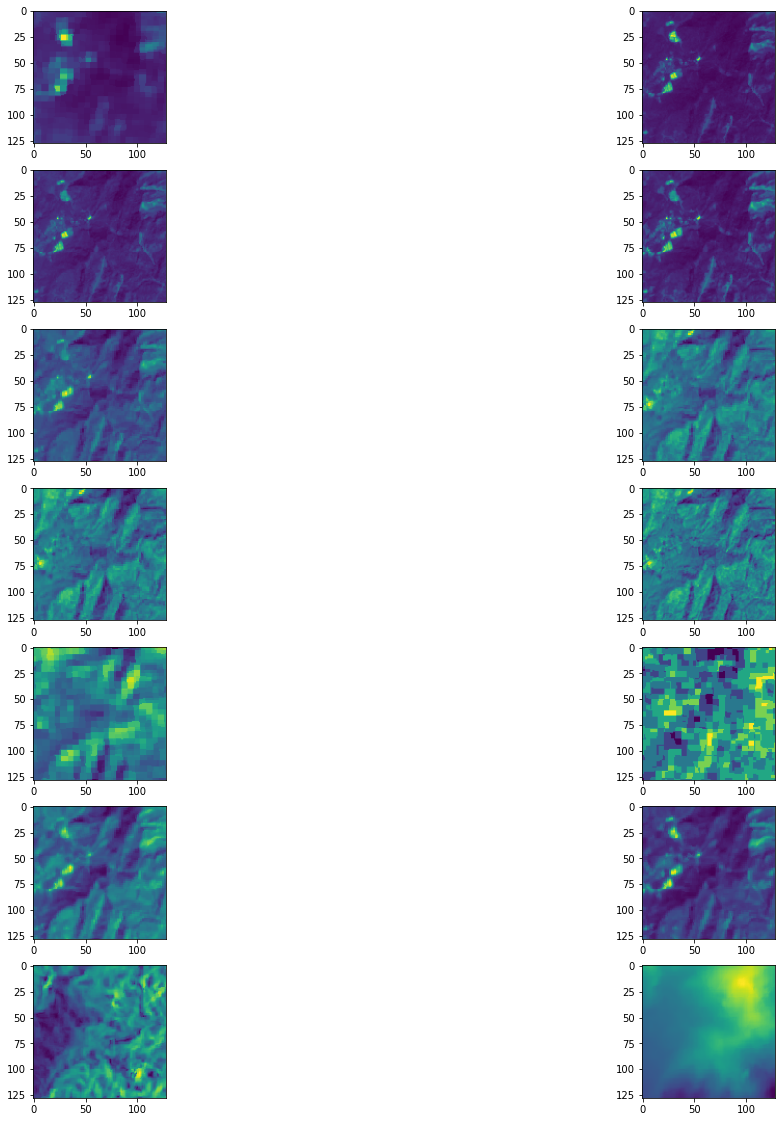

In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import h5py
import pandas as pd

# Load an h5py file
example_dt = h5py.File(r'image_1.h5','r')

# see what is inside that h5 file
print(example_dt.keys())

images = example_dt['img']
print(images.shape)

plt.subplots(7,2,figsize = (20,20))

#Plot the bands
for i in range(14):
    img_np = images[:,:,i]
    plt.subplot(7,2,1+i)
    plt.imshow(img_np)
plt.show()

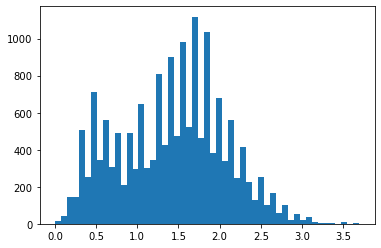

In [4]:
# The ALOS PALSAR products are very noisy, note the serrated histogram of the slope
slope= images[:,:,12]
slope= np.reshape(slope, -1)
plt.hist(slope, bins='auto'); #Noisy data, high and low values

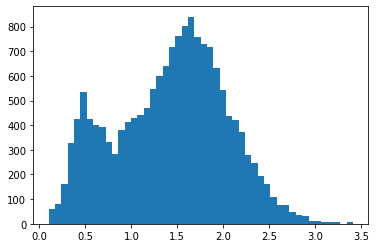

In [5]:
# Reduce dem noise with a box filter (averaging)
import cv2 as cv
k = 5 #smoothing factor
filtered_slope = cv.blur(slope,(k,k))
filtered_slope= np.reshape(filtered_slope, -1)
plt.hist(filtered_slope, bins="auto"); #more uniform histogram

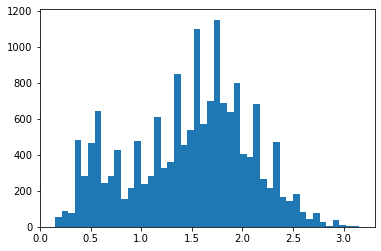

In [29]:
# Another filtering approach (median filter)
from scipy.ndimage import median_filter

filtered_slope=median_filter(slope, size=10)
filtered_slope= np.reshape(filtered_slope, -1)
plt.hist(filtered_slope, bins="auto"); #Not as good as the box filter

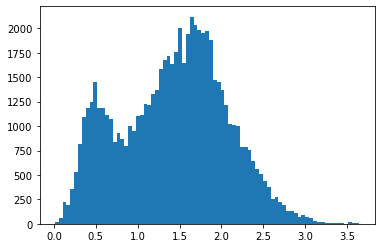

In [57]:
# Last approach for resampling DEM and calculating slope

from PIL import Image
import os
from osgeo import gdal
import richdem as rd

slope = Image.fromarray(images[:,:,12]) #transform array into tiff because rasterio can only open .tiff
slope.save("slope.tiff")
ds= gdal.Open("slope.tiff")

import rasterio
from rasterio.enums import Resampling

upscale_factor=2
with rasterio.open("slope.tiff") as dataset:
    # resample data to target shape
    upscaled_slope = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    
upscaled_slope= upscaled_slope[0,:,:]

upscaled_slope= np.reshape(upscaled_slope, -1)
plt.hist(upscaled_slope, bins='auto');

#Upscaling the raster also reduces noise. However, it is very unconvenient that rasterio is only able to read .tiff files.
#For this reason we will use the box filter.